In [2]:
#This Tells Python (usually in Jupyter/Colab) to run a system command to download and install libraries(packages)
!pip install GEOparse pandas numpy scikit-learn matplotlib seaborn rpy2


In [3]:
# IMPORT LIBRARIES
import GEOparse #Downloads and reads gene expression data from GEO (bioinformatics)

import pandas as pd #pandas reads CSV files into DataFrames (tables like Excel)# 

import numpy as np #Fast math and arrays (numbers, matrices)

#Machine learning tools:Train a Machine Learning Model:Use Random Forest (very good for biology)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt #Basic plotting (graphs)

import seaborn as sns#Prettier statistical plots (built on matplotlib)

import gzip

from mygene import MyGeneInfo

In [4]:

# Downloading and load this data (GSE24185) from GEO database
my_data_from_GEO = GEOparse.get_GEO("GSE24185", destdir="./my_GEO_data/")
#my_data_from_GEO now contains sample information, metadata and links to expression data


07-Feb-2026 10:51:17 DEBUG utils - Directory ./my_GEO_data/ already exists. Skipping.
07-Feb-2026 10:51:17 INFO GEOparse - File already exist: using local version.
07-Feb-2026 10:51:17 INFO GEOparse - Parsing ./my_GEO_data/GSE24185_family.soft.gz: 
07-Feb-2026 10:51:17 DEBUG GEOparse - DATABASE: GeoMiame
07-Feb-2026 10:51:17 DEBUG GEOparse - SERIES: GSE24185
07-Feb-2026 10:51:17 DEBUG GEOparse - PLATFORM: GPL96
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594855
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594856
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594857
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594858
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594859
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594860
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594861
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594862
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594863
07-Feb-2026 10:51:18 DEBUG GEOparse - SAMPLE: GSM594864
07-Feb-2026 10:51:18 DEBU

In [5]:
# Converts the GEO data into a table (matrix) of gene expression values
expression_data = my_data_from_GEO.pivot_samples('VALUE')
#expression_data  now becomes a pandas DataFrame like a excel where each cell has expression level for one gene in the sample
    #ROWS becomes GENES/PROBES
    #COLUMNS becomes SAMPLES with expression values

In [6]:
expression_data.shape

(22283, 103)

In [7]:
expression_data.head()

name,GSM594855,GSM594856,GSM594857,GSM594858,GSM594859,GSM594860,GSM594861,GSM594862,GSM594863,GSM594864,...,GSM594948,GSM594949,GSM594950,GSM594951,GSM594952,GSM594953,GSM594954,GSM594955,GSM594956,GSM594957
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,9.66,10.01,9.48,10.30,10.45,9.59,9.18,9.70,10.08,9.44,...,9.77,9.44,9.08,9.38,10.74,9.00,10.35,10.28,10.81,10.58
1053_at,7.00,7.22,7.49,7.70,7.59,8.13,7.79,7.41,7.34,7.11,...,7.21,7.83,7.67,7.39,8.07,7.56,7.04,7.12,7.38,7.75
117_at,7.68,7.74,8.00,7.71,7.56,7.65,7.38,8.28,7.86,7.62,...,8.33,7.85,7.55,7.60,7.49,7.86,7.62,7.68,7.77,7.43
121_at,9.25,9.48,9.36,9.60,9.92,9.79,9.49,9.49,9.44,9.69,...,9.49,9.66,9.48,9.70,9.61,9.18,8.91,8.91,9.22,9.48
1255_g_at,7.35,7.42,7.96,8.02,7.99,8.00,7.71,7.29,7.25,7.54,...,7.25,8.07,8.19,7.57,7.86,8.30,8.26,7.32,7.32,8.16


In [8]:
#Show the IDs of the gene expression platforms used in this GEO study
my_data_from_GEO.gpls.keys() ##gpls stands for GEO Platforms. These platforms tells you what technology and probes were used to measure genes

dict_keys(['GPL96'])

In [9]:
#This code looks inside the platform with ID GPL96
gpl = my_data_from_GEO.gpls['GPL96']


In [10]:
#This extracts the actual gene annotation table
gpl_table = gpl.table

In [11]:
gene_map = gpl_table[['ID', 'Gene Symbol','Gene Title']] #Select only the columns ID and Gene Symbol

#Basically renaming them
gene_map = gene_map.rename(columns={
    'ID': 'probe_id',
    'Gene Symbol': 'gene_name',
    'Gene Title': 'gene_title'
})


In [12]:
#Microarray data uses technical probe IDs, which are not interpretable biologically
#This merge adds the actual gene symbols for each probe
expression_data_named = expression_data.copy()

expression_data_named = expression_data_named.merge(
    gene_map,
    left_index=True,
    right_on='probe_id',
    how='left'
)


In [13]:
#These two lines are the final cleaning steps to make your expression data fully biologically interpretable
expression_data_named = expression_data_named.set_index('gene_name')
expression_data_named = expression_data_named.drop(columns=['probe_id'])


In [14]:
#Removes duplication of genes since microarray platform often have multiple probes measuring the same gene.
#Now each gene appears exactly once, with average expression across probes.
# Numeric expression columns
expr_cols = expression_data_named.select_dtypes(include='number').columns
# Text column (gene description)
text_cols = ['gene_title']


In [15]:
# Aggregate numeric expression values by mean
numeric_agg = expression_data_named[expr_cols].groupby(expression_data_named.index).mean()

# Keep gene_title column, first value per gene
gene_title_agg = expression_data_named[text_cols].groupby(expression_data_named.index).first()


In [16]:
# Concatenate gene_title first, then numeric data
expression_data_named = pd.concat([gene_title_agg, numeric_agg], axis=1)


In [17]:
expression_data_named

,gene_title,GSM594855,GSM594856,GSM594857,GSM594858,GSM594859,GSM594860,GSM594861,GSM594862,GSM594863,...,GSM594948,GSM594949,GSM594950,GSM594951,GSM594952,GSM594953,GSM594954,GSM594955,GSM594956,GSM594957
gene_name,,,,,,,,,,,,,,,,,,,,,
A1CF,APOBEC1 complementation factor,8.780000,8.610000,8.570000,10.320000,9.840000,9.810000,9.120000,8.84,9.750,...,8.540000,10.100,9.710000,9.320000,9.620,9.230000,9.130,8.820000,9.130000,9.810000
A2M,alpha-2-macroglobulin,10.050000,10.370000,9.950000,9.930000,10.860000,11.100000,9.530000,10.77,10.880,...,10.600000,11.010,10.450000,11.810000,11.590,9.890000,9.420,10.450000,10.430000,10.600000
A4GALT,"alpha 1,4-galactosyltransferase",6.030000,6.420000,5.290000,5.970000,6.320000,5.720000,6.310000,6.21,5.630,...,6.840000,5.810,6.400000,5.670000,5.990,7.080000,5.720,4.670000,5.600000,4.750000
A4GNT,"alpha-1,4-N-acetylglucosaminyltransferase",7.150000,7.360000,7.720000,8.040000,7.670000,7.750000,7.550000,7.13,7.770,...,7.560000,8.120,7.740000,8.100000,7.960,8.370000,7.750,7.530000,7.700000,8.230000
AAAS,"achalasia, adrenocortical insufficiency, alacr...",7.220000,7.060000,7.360000,7.030000,7.320000,7.190000,7.380000,7.54,6.800,...,7.360000,7.090,7.190000,7.390000,7.050,7.150000,7.190,7.100000,7.530000,7.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,ZXD family zinc finger C,7.430000,7.360000,7.160000,7.490000,7.480000,6.990000,6.770000,7.13,6.910,...,7.170000,6.560,7.110000,6.690000,7.210,7.070000,7.260,8.110000,7.610000,6.610000
ZYX,zyxin,8.890000,8.055000,7.950000,7.930000,7.775000,7.475000,7.740000,8.25,7.545,...,8.290000,7.745,7.775000,8.100000,7.515,7.960000,7.965,7.995000,7.665000,7.590000
ZZEF1,"zinc finger, ZZ-type with EF-hand domain 1",7.423333,7.543333,7.526667,7.436667,7.663333,7.526667,7.453333,7.57,7.260,...,7.536667,7.270,7.416667,7.456667,7.160,7.386667,7.560,7.453333,7.653333,7.326667


In [18]:

# Extract clinical/phenotype data grom GEO dataset i downloaded
clinical_data = my_data_from_GEO.phenotype_data
#clinical_data now- 
    #ROWS has SAMPLES
    #COLUMNS has things like disease status, treatment, age, bmi



In [19]:
clinical_data.shape

(103, 42)

In [53]:
clinical_data.head()

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count,BMI,BMI_group
GSM594855,patient 633,GSM594855,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,19.92,Non-Obese
GSM594856,patient 644,GSM594856,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,19.72,Non-Obese
GSM594857,patient 665,GSM594857,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,23.74,Non-Obese
GSM594858,patient 671,GSM594858,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,23.88,Non-Obese
GSM594859,patient 675,GSM594859,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,24.91,Non-Obese


In [20]:

# Show first 5 rows
print(expression_data_named.head())


                                                  gene_title  GSM594855  \
gene_name                                                                 
A1CF                          APOBEC1 complementation factor       8.78   
A2M                                    alpha-2-macroglobulin      10.05   
A4GALT                       alpha 1,4-galactosyltransferase       6.03   
A4GNT              alpha-1,4-N-acetylglucosaminyltransferase       7.15   
AAAS       achalasia, adrenocortical insufficiency, alacr...       7.22   

           GSM594856  GSM594857  GSM594858  GSM594859  GSM594860  GSM594861  \
gene_name                                                                     
A1CF            8.61       8.57      10.32       9.84       9.81       9.12   
A2M            10.37       9.95       9.93      10.86      11.10       9.53   
A4GALT          6.42       5.29       5.97       6.32       5.72       6.31   
A4GNT           7.36       7.72       8.04       7.67       7.75       7.55   


In [21]:
#Saves the expression data as a CSV file (like an Excel file).
expression_data_named.to_csv("my_data_from_GEO_expression.csv")

# The file is now stored in my local desktop directory

In [22]:
#Saves the clinical data as a CSV file (like an Excel file).
clinical_data.to_csv("my_data_from_GEO_clinical.csv")

# The file is now stored in my local desktop directory

In [23]:
#reload it to avoid downloading from GEO again
expression_data_named = pd.read_csv("my_data_from_GEO_expression.csv", index_col=0)

In [24]:
#reload it to avoid downloading from GEO again
clinical_data = pd.read_csv("my_data_from_GEO_clinical.csv", index_col=0)


In [25]:
#This function turns a numeric BMI into a categorical label for binary analysis.
#clinical_data['BMI'] this code creates a new column in my clinical data called BMI
clinical_data['BMI'] = clinical_data['characteristics_ch1.4.bmi'].astype(float)

In [54]:
# Create BMI group: Obese vs Non-Obese
def bmi_group(bmi):
    if bmi is None:
        return 'Unknown' # optional, depends if you want to include missing values
    elif bmi >= 30:
        return 'Obese'
    else:
        return 'Non-Obese'

In [27]:
#This function turns a numeric BMI into a categorical label for binary analysis.i.e obese or non obese
#It creates another column in my clinical data called BMI_group
clinical_data['BMI_group'] = clinical_data['BMI'].apply(bmi_group)

In [28]:
# Count the number of samples in each binary group
print(clinical_data['BMI_group'].value_counts())

BMI_group
Non-Obese    66
Obese        37
Name: count, dtype: int64


In [29]:
#since my original data had all patient, now this code cleans it and only remains with patient with BMI values only
# Keep only patients with BMI
clinical_data_clean = clinical_data.dropna(subset=['BMI'])


In [30]:
print("Patients  with BMI:", clinical_data_clean.shape[0])


Patients  with BMI: 103


In [31]:
clinical_data_clean['BMI_group'].value_counts()

BMI_group
Non-Obese    66
Obese        37
Name: count, dtype: int64

FILTRATION  OF DATA

In [32]:
#filter for Obese and Non-Obese patients for analysis:
mask = clinical_data_clean['BMI_group'].isin(['Obese', 'Non-Obese'])
#mask Stores the result as a Boolean mask (a True/False Series)

In [33]:
#.loc[mask] Uses the Boolean mask to select only rows where mask == True
clinical_filtered = clinical_data_clean.loc[mask] 

In [34]:
#confirm that:Only Obese and Non-Obese patients remain
clinical_filtered['BMI_group'].value_counts()

BMI_group
Non-Obese    66
Obese        37
Name: count, dtype: int64

First have a glance at how the two tables look before combining

In [35]:
clinical_filtered.head()

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count,BMI,BMI_group
GSM594855,patient 633,GSM594855,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,19.92,Non-Obese
GSM594856,patient 644,GSM594856,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,19.72,Non-Obese
GSM594857,patient 665,GSM594857,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,23.74,Non-Obese
GSM594858,patient 671,GSM594858,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,23.88,Non-Obese
GSM594859,patient 675,GSM594859,Public on Jul 18 2011,Sep 17 2010,Jul 18 2011,RNA,1,human breast tumor,Homo sapiens,9606,...,"One Baylor Plaza, Mail Stop: BCM305",Houston,TX,77030,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM594n...,GSE24185,22283,24.91,Non-Obese


In [36]:
expression_data_named.head()

,gene_title,GSM594855,GSM594856,GSM594857,GSM594858,GSM594859,GSM594860,GSM594861,GSM594862,GSM594863,...,GSM594948,GSM594949,GSM594950,GSM594951,GSM594952,GSM594953,GSM594954,GSM594955,GSM594956,GSM594957
gene_name,,,,,,,,,,,,,,,,,,,,,
A1CF,APOBEC1 complementation factor,8.78,8.61,8.57,10.32,9.84,9.81,9.12,8.84,9.75,...,8.54,10.10,9.71,9.32,9.62,9.23,9.13,8.82,9.13,9.81
A2M,alpha-2-macroglobulin,10.05,10.37,9.95,9.93,10.86,11.10,9.53,10.77,10.88,...,10.60,11.01,10.45,11.81,11.59,9.89,9.42,10.45,10.43,10.60
A4GALT,"alpha 1,4-galactosyltransferase",6.03,6.42,5.29,5.97,6.32,5.72,6.31,6.21,5.63,...,6.84,5.81,6.40,5.67,5.99,7.08,5.72,4.67,5.60,4.75
A4GNT,"alpha-1,4-N-acetylglucosaminyltransferase",7.15,7.36,7.72,8.04,7.67,7.75,7.55,7.13,7.77,...,7.56,8.12,7.74,8.10,7.96,8.37,7.75,7.53,7.70,8.23
AAAS,"achalasia, adrenocortical insufficiency, alacr...",7.22,7.06,7.36,7.03,7.32,7.19,7.38,7.54,6.80,...,7.36,7.09,7.19,7.39,7.05,7.15,7.19,7.10,7.53,7.15


In [37]:
#Find Patients who are common in clinical data and expression data
common_patients = clinical_filtered.index.intersection(expression_data_named.columns)

In [38]:
print("These are the common patients in the two two tables", common_patients.shape)

These are the common patients in the two two tables (103,)


In [39]:
# Ensure same patients and same order i.e
    #Make sure clinical data and gene expression data match patient-by-patient.
common_patients = common_patients.sort_values()

clinical_filtered = clinical_filtered.loc[common_patients, :]
expression_data_named = expression_data_named.loc[:, common_patients]



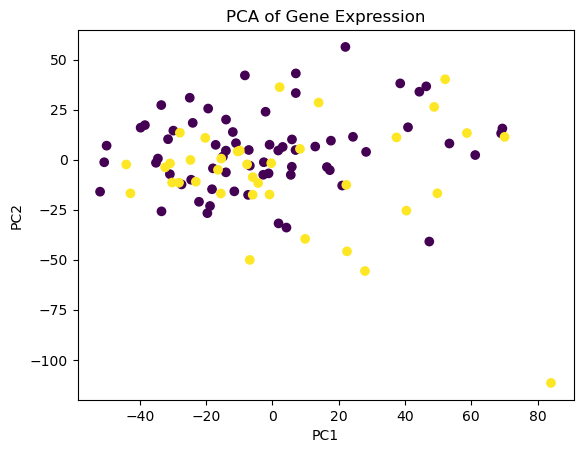

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Transpose: PCA(Principal Component Analysis) expects samples as rows
X = expression_data_named.T #This is basically transposing the expression_data to be used in PCA(a statistical method) which uses rows as patients and genes as columns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=(clinical_filtered['BMI_group'] == 'Obese'),
)
plt.xlabel('PC1') #largest source of variation in gene expression
plt.ylabel('PC2')#second largest source of variation
plt.title('PCA of Gene Expression')
plt.show()


In [41]:
#Explaining the results above.
#There is strong overlap between obese and non-obese samples. 
    #The two colors are mixed together
    #No clean separation along PC1
    #No clean separation along PC2
    
#Biologically it means BMI is NOT the dominant driver of global gene expression variation in this dataset


In [42]:
print(pca.explained_variance_ratio_)
#The results means
   # PC1 explains 16% of total gene expression variation
    #PC2 explains 0.9%
    #Together: 25%

[0.16376675 0.09812206]


PREPARE GROUPS FOR TESTING

DIFFERENTIAL EXPRESSION (CORE STEP)
Here i will switch to R

In [48]:
#I want to export my expression data to R now
expression_data_named.to_csv("expression_data_for_R.csv")

In [49]:
expression_data_named.shape

(13515, 103)

In [50]:
#I want to export my clinical data to R now
clinical_filtered.to_csv("clinical_data_for_R.csv", index=False)

In [51]:
clinical_filtered.shape

(103, 44)

In [52]:
head.clinical_data

NameError: name 'head' is not defined